# Graph testing
This is a notebook that can be used to play around with graphs and get instant feedback (instead of passing it to html and running the server.)

# Table of contents

1. [Setup code](#Setup-code)
1. [Record statuses](#Record-statuses)
1. [Statuses of parents/children](#Statuses-of-parents/children)
1. [Potential database issues](#Potential-database-issues)

## Setup code

It was tricky to get Jupyter to run Django, and I hope it is reproducible.  To run this, Jupyter must be launched from within pipenv.  And while there might be a way to run a notebook in a subdirectory, I could only get it to work when the notebook is in the root folder.

In [1]:
import os, sys
configuration = os.getenv('ENVIRONMENT', 'development').title()
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'planningportal.settings')
os.environ.setdefault('DJANGO_CONFIGURATION', configuration)
from configurations.management import execute_from_command_line
import django
django.setup()

In [2]:
if 'ppts.views' in sys.modules:
    del sys.modules['ppts.views'] 
from ppts.views import *

%matplotlib inline

In [3]:
import pandas as pd
import datetime
from django.db.models import Q
from django.db.models import F

## Record statuses

In [20]:
def pie_from_counts(query, label_key, counts_key):
    '''Generates a pie chart from a query, and returns DataFrame with results.'''
    counts = []
    labels = []
    for item in query:
        labels.append(item[label_key])
        counts.append(item[counts_key])
    fig,ax = plt.subplots(figsize=(4,4))
    plt.show(ax.pie(counts, labels=labels))
    
    counts_table = pd.DataFrame({'label':labels,'counts':counts})
    return counts_table

In [260]:
projects = Record.objects.filter(record_type__pk = 'PRJ').values('status').annotate(status_counts = Count('pk'))
print(projects)

<QuerySet [{'status_counts': 251, 'status': 'Accepted'}, {'status_counts': 1, 'status': 'Actions Pending'}, {'status_counts': 330, 'status': 'Application Accepted'}, {'status_counts': 6, 'status': 'Approved'}, {'status_counts': 36689, 'status': 'Closed'}, {'status_counts': 12, 'status': 'Closed - Approved'}, {'status_counts': 1, 'status': 'Closed - Complete'}, {'status_counts': 141, 'status': 'Closed - Withdrawn'}, {'status_counts': 7, 'status': 'Complete'}, {'status_counts': 1, 'status': 'Denied'}, {'status_counts': 1, 'status': 'Disapproved'}, {'status_counts': 1, 'status': 'Incomplete'}, {'status_counts': 14, 'status': 'On Hold'}, {'status_counts': 226, 'status': 'Open'}, {'status_counts': 14, 'status': 'Pending'}, {'status_counts': 1, 'status': 'Pending Review'}, {'status_counts': 47, 'status': 'Submitted'}, {'status_counts': 1938, 'status': 'Under Review'}, {'status_counts': 573, 'status': 'Withdrawn'}, {'status_counts': 114, 'status': 'nan'}]>


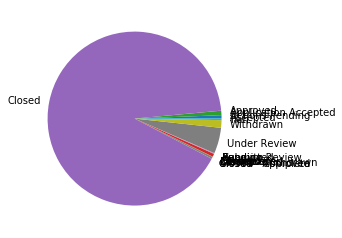

    counts                 label
0      251              Accepted
1        1       Actions Pending
2      330  Application Accepted
3        6              Approved
4    36689                Closed
5       12     Closed - Approved
6        1     Closed - Complete
7      141    Closed - Withdrawn
8        7              Complete
9        1                Denied
10       1           Disapproved
11       1            Incomplete
12      14               On Hold
13     226                  Open
14      14               Pending
15       1        Pending Review
16      47             Submitted
17    1938          Under Review
18     573             Withdrawn
19     114                   nan
Total number of records: 40368


In [129]:
#pie chart for all projects
projects = Record.objects.filter(record_type__pk = 'PRJ').values('status').annotate(status_counts = Count('pk'))
table = pie_from_counts(projects,'status','status_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

Here's the problem: "Closed" includes records whose status is unknown, even to the planning department!  They say that some of these come from legacy records, where the status could not be accurately determined.  I think some of them have been approved, but it's lumped together in a way that we're not actually sure.  (Note: "Accepted" does not mean "approved" and just means the application met minimum requirements to begin consideration.)

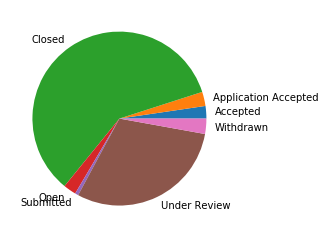

   counts                 label
0      45              Accepted
1      51  Application Accepted
2    1145                Closed
3      46                  Open
4      12             Submitted
5     581          Under Review
6      55             Withdrawn
Total number of records: 1935


In [137]:
#Limit to projects from 2018
projects = Record.objects.filter(record_type__pk = 'PRJ').filter(
    date_opened__lt=datetime.date(2019, 1, 1), date_opened__gt=datetime.date(2018, 1, 1)
    ).values('status').annotate(status_counts = Count('pk'))
table = pie_from_counts(projects,'status','status_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

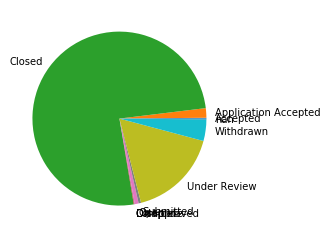

    counts                 label
0        3              Accepted
1       35  Application Accepted
2     1497                Closed
3        2              Complete
4        1           Disapproved
5        1               On Hold
6       14                  Open
7        9             Submitted
8      333          Under Review
9       79             Withdrawn
10       3                   nan
Total number of records: 1977


In [164]:
#limit to projects that increase the number of market rate units OR affordable units
projects = Record.objects.filter(record_type__pk = 'PRJ').filter(
    Q(projectfeature__type=ProjectFeature.MARKET_RATE, projectfeature__net__gt=0) |
    Q(projectfeature__type=ProjectFeature.AFFORDABLE, projectfeature__net__gt=0) 
    ).values('status').annotate(status_counts = Count('pk',distinct=True))
#note the 'distinct' parameter is set to True, which is necessary because 
#there's an implicit join between tables that duplicates some of the entries of the Record table.
table = pie_from_counts(projects,'status','status_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

## Statuses of parents/children
I'd like to try finding more information about projects by looking at related (parent & child) records.  But first, we need to characterize this aspect of the data.  How many PRJ records even have children or parents?  What kind of records are the children and parents?

In [13]:
housing_projects = Record.objects.filter(record_type__pk = 'PRJ').filter(
    Q(projectfeature__type=ProjectFeature.MARKET_RATE, projectfeature__net__gt=0) |
    Q(projectfeature__type=ProjectFeature.AFFORDABLE, projectfeature__net__gt=0) )
child_records = Record.objects.filter(parent__record_type__pk = 'PRJ').filter(
    Q(parent__projectfeature__type=ProjectFeature.MARKET_RATE, parent__projectfeature__net__gt=0) |
    Q(parent__projectfeature__type=ProjectFeature.AFFORDABLE, parent__projectfeature__net__gt=0) )
parent_records = Record.objects.filter(child__record_type__pk = 'PRJ').filter(
    Q(child__projectfeature__type=ProjectFeature.MARKET_RATE, child__projectfeature__net__gt=0) |
    Q(child__projectfeature__type=ProjectFeature.AFFORDABLE, child__projectfeature__net__gt=0) )

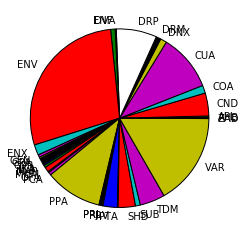

    counts label
0        2   AHB
1        4   APL
2       61   CND
3       21   COA
4      151   CUA
5       17   DNX
6       13   DRM
7      108   DRP
8        3   DVA
9       12   ENF
10     416   ENV
11      28   ENX
12       7   GEN
13       4   GPA
14      16   GPR
15       1   IKA
16       4   LLA
17       6   MAP
18      13   MCM
19       3   OFA
20       8   PCA
21     152   PPA
22       9   PRJ
23       2   PRL
24      38   PRV
25       2   PTA
26      46   SHD
27      13   SUB
28      67   TDM
29     245   VAR
30       1   ZAD
Total number of records: 1473


In [21]:
#look at the types of records that are children of housing PRJ records
child_types = child_records.values('record_type').annotate(type_counts = Count('pk',distinct=True))
table = pie_from_counts(child_types,'record_type','type_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

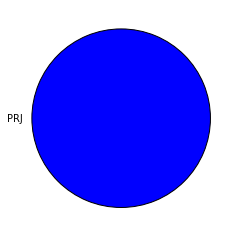

   counts label
0       6   PRJ
Total number of records: 6


In [22]:
#Now look at the records whose parents are housing PRJ records
parent_types = parent_records.values('record_type').annotate(type_counts = Count('pk',distinct=True))
table = pie_from_counts(parent_types,'record_type','type_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

So it looks like we can do something with this!  Most PRJ records don't have parents, except for other PRJ records.  The child records appear to be a variety of related permits.  So all we need to do is look at the statuses of the child records.

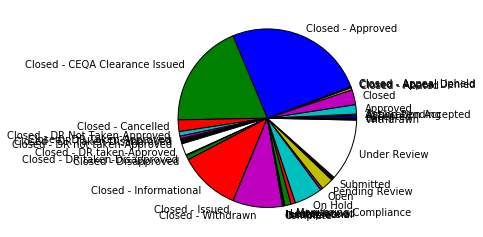

    counts                           label
0        7                        Accepted
1        2                  Action Pending
2        2            Application Accepted
3       25                        Approved
4       40                          Closed
5        6                 Closed - Abated
6        2          Closed - Appeal Denied
7        1          Closed - Appeal Upheld
8      376               Closed - Approved
9      280  Closed - CEQA Clearance Issued
10      31              Closed - Cancelled
11      12  Closed - DR Not Taken-Approved
12       7      Closed - DR Taken-Approved
13       2   Closed - DR Taken-Disapproved
14      12  Closed - DR not taken-Approved
15      31      Closed - DR taken-Approved
16       2   Closed - DR taken-Disapproved
17      12            Closed - Disapproved
18     162          Closed - Informational
19       1                 Closed - Issued
20     132              Closed - Withdrawn
21       1                        Complete
22       1 

In [23]:
child_types = child_records.values('status').annotate(type_counts = Count('pk',distinct=True))
table = pie_from_counts(child_types,'status','type_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

I'll have to ask later what all these different statuses mean, but I'll make a rough grouping for now into "Approved", "Rejected", "Pending", and "Unknown".  Approved means that it went through without issue.  Rejected means that it failed to go through (although a later attempt may have succeeded).

In [26]:
distinct_statuses = Record.objects.values('status').distinct().all()
for status in distinct_statuses:
    print(status['status'])

Open
Accepted
Under Review
Closed
On Hold
Pending Review
Closed - Approved
Closed - Disapproved
Closed - No Violation
Closed - CEQA Clearance Issued
Application Accepted
Closed - Withdrawn
Closed - Cancelled
Closed - Informational
Withdrawn
Pending Closure
Closed - Issued
Closed - Abated
Monitoring Compliance
Submitted
Complete
Informational
Approved
Permitted
Closed - DR Not Taken-Approved
Closed - Appeal Denied
Closed - Appeal Upheld
Issued
Closed - No DR action-Approved
Closed - DR not taken-Approved
Closed - DR taken-Approved
Consultation
nan
Public Review Period
Closed - Removed
Pending
Denied
Closed - DR taken-Disapproved
Closed - DR Taken-Disapproved
Pending Voluntary Removal
Closed - DR Taken-Approved
Appeal Denied
Closed - Complete
Appeal Upheld
Letter Issued
Case Closed
Appeal Pending
TDR Letter Issued
Closed - No DR Action-Approved
Cancelled
Closed-Informational
Action Pending
Disapproved
Incomplete
Recommend Approval
In Development
Actions Pending
Project Withdrawn
Approval

In [27]:
#I'll probably make this case-insensitive, but for now I include distinct cases
status_approved = ['Closed - Approved', 'Closed - No Violation',
                   'Closed - CEQA Clearance Issued', 'Application Accepted',
                   'Closed - Informational', 'Closed - Issued', 'Closed - Abated',
                   'Complete', 'Informational', 'Approved', 'Permitted',
                  'Closed - DR Not Taken-Approved', 'Closed - Appeal Upheld',
                  'Issued', 'Closed - No DR action-Approved', 'Closed - DR not taken-Approved',
                  'Closed - DR taken-Approved', 'Consultation', 'Closed - DR Taken-Approved',
                  'Appeal Upheld', 'Letter Issued', 'TDR Letter Issued',
                   'Closed - No DR Action-Approved', 'Closed-Informational',
                   'Recommend Approval', 'Approval BOS', 'Filed', 'Appealed']
status_rejected = ['Closed - Disapproved', 'Closed - Withdrawn', 'Closed - Cancelled',
                   'Withdrawn', 'Closed - Appeal Denied', 'Denied',
                  'Closed - DR taken-Disapproved','Closed - DR Taken-Disapproved',
                  'Appeal Denied', 'Cancelled', 'Disapproved', 'Incomplete',
                  'Project Withdrawn']
status_pending = ['Open', 'Accepted', 'Under Review', 'Closed', 'On Hold', 'Pending Review',
                  'Pending Closure', 'Monitoring Compliance', 'Submitted', 
                 'Public Review Period', 'Pending', 'Pending Voluntary Removal',
                 'Appeal Pending','Action Pending', 'In Development', 'Actions Pending']
status_unknown = ['Closed - Removed', 'Closed - Complete', 'Case Closed']

In [31]:
#show how many children are approved/rejected/pending/unknown
print('Approved: %s' % child_records.filter(status__in=status_approved).count())
print('Rejected: %s' % child_records.filter(status__in=status_rejected).count())
print('Pending: %s' % child_records.filter(status__in=status_pending).count())
print('Unknown: %s' % child_records.filter(status__in=status_unknown).count())

Approved: 1134
Rejected: 198
Pending: 437
Unknown: 0


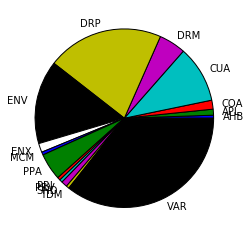

    counts label
0        1   AHB
1        2   APL
2        3   COA
3       19   CUA
4        9   DRM
5       39   DRP
6       28   ENV
7        3   ENX
8        1   MCM
9        9   PPA
10       1   PRJ
11       1   PRV
12       2   SHD
13       1   TDM
14      66   VAR
Total number of records: 185


In [28]:
#Now let's just see where the rejections are
rejected_children = child_records.filter(status__in=status_rejected).values('record_type').annotate(type_counts = Count('pk',distinct=True))
table = pie_from_counts(rejected_children,'record_type','type_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

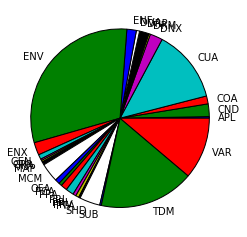

    counts label
0        1   APL
1        8   CND
2        5   COA
3       46   CUA
4        8   DNX
5        1   DRM
6        6   DRP
7        2   DVA
8        6   ENF
9      107   ENV
10       8   ENX
11       3   GEN
12       1   GPR
13       1   IKA
14       2   MAP
15      12   MCM
16       3   OFA
17       2   PCA
18       4   PPA
19       5   PRJ
20       2   PRL
21       2   PRV
22       1   PTA
23      13   SHD
24       1   SUB
25      60   TDM
26      39   VAR
Total number of records: 349


In [29]:
#And what kinds of records are still pending?
pending_children = child_records.filter(status__in=status_pending).values('record_type').annotate(type_counts = Count('pk',distinct=True))
table = pie_from_counts(pending_children,'record_type','type_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

## Potential database issues
Just noting some database issues as I run into them.

### Parent-child relationship (resolved)
Resolution: Modified the parent ManyToManyField to include the parameter `symmetrical=False`.  The database now works as intended.

For some reason the parent-child relationship doesn't work entirely correctly.

The Record model includes a ManyToMany relationship to itself, where each record includes a list of all parents.  Given a particular record, it is possible to get all the parents, and it is possible to filter on the properties of the parents.

In [4]:
#get all parents of a record
r = Record.objects.get(pk=109391)
print(r.parent.all())

<QuerySet [<Record: Record object (90111)>]>


In [5]:
#filter on properties of parent
q = Record.objects.filter(parent__pk=109391)
print(q)

<QuerySet [<Record: Record object (1171)>]>


It should also be possible to perform the reverse operations, using the `related_name` parameter of the ManyToManyField.  In the Record model, the `related_name` parameter is set to 'child'.  However, operations using the keyword 'child' are not recognized.

In [8]:
#try filtering on properties of child
q = Record.objects.filter(child__pk=109391)
print(q)

<QuerySet [<Record: Record object (90111)>]>


What *is* possible, is querying the through table.

In [9]:
#Query the through table, and filter out all entries where the child field is 109391
rel = Record.parent.through.objects.filter(from_record=109391)
#print out the parent field for the first such entry
print(rel[0].to_record)

Record object (90111)


In [10]:
#Query the through table, and filter out all entries where the parent field is 109391
rel = Record.parent.through.objects.filter(from_record=109391)
#print out the child field for the first such entry
print(rel[0].from_record)

Record object (109391)


In conclusion, the relevant information is in the database, but for some reason the queries using `related_name` do not work properly.  I suspect it may be a problem in the construction of the database